# MAP推定

最大事後確率（*Maximum a posteriori*）推定。あるデータ$X$が得られた時、事後確率が最も高くなるパラメータ$\theta$を推定する。

$$
\argmax_{\theta} p(\theta|X)
$$

In [1]:
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt

まず、MAP推定を学ぶ上で必要な概念を理解する。


---

## ベイズの定理

条件付き確率に関する以下の公式。

$$
p(A|B) = \frac{p(B|A)p(A)}{p(B)}
$$

A,Bは何らかの事象。Aが原因でBを結果だとすると、原因Aの元で結果Bが起きる確率$p(B|A)$という求めやすい値から、その逆の確率$P(A|B)$を求められる。$p(A)$は事前分布、$p(A|B)$は事後分布と呼ぶ。

<br>

よくある例題
- [病気に罹患している確率は？　ベイズの定理で求める方法を解説／『Pythonで動かして学ぶ！』シリーズ|CodeZine（コードジン）](https://codezine.jp/article/detail/14581)


---

## 事後分布

データ$X$とパラメータ$\theta$でもベイズの定理を適用することができる。

$$
p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)}
$$

- $p(\theta|X)$: 事後分布。データ$X$が得られた時、そのデータがパラメータ$\theta$（に従う分布）から生成された確率。
- $p(X|\theta)$: 尤度。パラメータ$\theta$の下でデータ$X$が得られる確率。
- $p(\theta)$: 事前分布。パラメータ$\theta$が得られる確率。
- $p(X)$: 周辺尤度: $p(X)=\int p(\theta)p(X|\theta) d\theta$。データ$X$が得られる確率。

<br>

MAP推定を行う際は、↑のようにベイズの定理を用いて式を変換する。

$$
\begin{align}
\argmax_{\theta} p(\theta|X) &= \argmax_{\theta} \frac{p(X|\theta)p(\theta)}{p(X)} \\
&= \argmax_{\theta} p(X|\theta)p(\theta) \\
\end{align}
$$

最尤推定で求めたものは以下であった。

$$
\argmax_{\theta} p(X|\theta)
$$

MAP推定では、**パラメータ$\theta$も確率変数とみなし**、$X$の尤度$p(X|\theta)$だけでなくそのパラメータ$\theta$が得られる確率（厳密には尤度）$p(\theta)$も考慮して$\theta$を推定する。  
事後分布は、$X$の尤度を$\theta$の尤度で重み付けしたものというイメージ。

また$p(\theta)$は事前分布と呼ばれ、**主観的**な知見を反映させるがある。


---

## 総当たりで求める

では実際にMAP推定を行ってみる。  
$\theta$の値を全て試して、事後確率が最大になる$\theta$を求める。（ここでの事後確率は、事後分布に具体的な$X, \theta$を代入した時に出てきた値という意味。）

例題

> 東京都に住む成人男性の平均身長を求めたい。アンケートを実施して、10000の標本を集めることができた。この10000人分のデータを元に、平均身長を求める。具体的には、身長が正規分布に従うと仮定し、その分布の平均値を求める。なお標準偏差は既知で$\sigma=10$とする。また、日本の成人男性の身長が平均170cm、標準偏差10cmの正規分布に従うことを知っているとする。

<br>

以下のような標本が得られたとしよう。

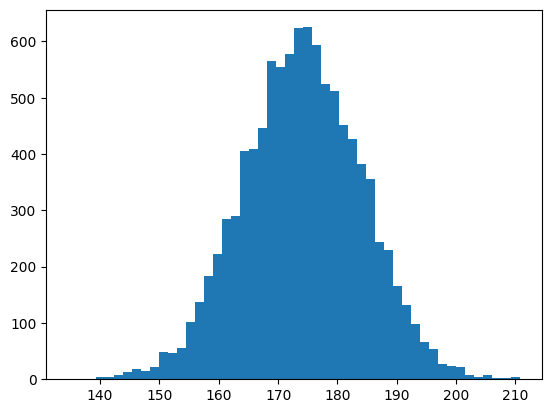

In [2]:
norm = dist.Normal(174, 10)
x = norm.sample((10000,))
plt.hist(x, bins=50);

この標本は平均174、標準偏差10の正規分布から得られている。

では実際に総当たりで求めていく。ただ今回は確率変数$x$（身長）が連続値で範囲が正の実数なので、適当に範囲と分解能を決めて離散化する。

In [3]:
theta = torch.arange(160, 180, 0.1) # 160~180までを0.1刻みで

次に事前分布を決める。今回は、日本の成人男性の身長の分布を知っているという設定がある。そしてそれはパラメータ$\theta$の事前分布として適しているだろうと考えられる。これは主観的な知見にあたる。

ということで、事前分布は日本の成人男性の身長の分布$\mathcal N(170, 10)$とする。

In [4]:
prior = dist.Normal(170, 10)

あとは計算をするだけ。

$$
\begin{align}
\argmax_{\theta} p(\theta|X) &= \argmax_{\theta} \frac{p(X|\theta)p(\theta)}{p(X)} \\
&= \argmax_{\theta} p(X|\theta)p(\theta) \\
\end{align}
$$

より、各$\theta$で以下を求め、最も大きくなった$\theta$を見つける。

$$
p(X|\theta)p(\theta)
$$

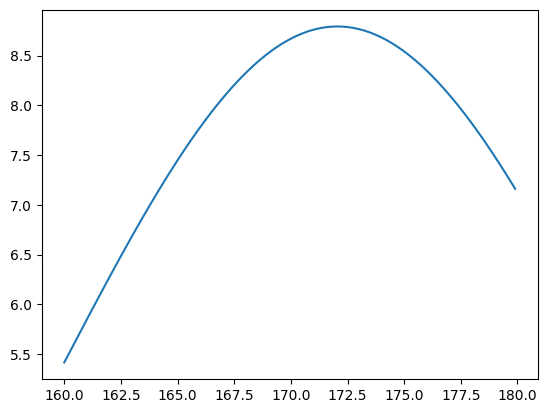

In [5]:
y = []
for t in theta:
    likelihood = dist.Normal(t, 10).log_prob(x).exp()
    prior_prob = prior.log_prob(x).exp()
    y_ = likelihood * prior_prob
    y.append(y_.sum().item())
plt.plot(theta, y);

In [6]:
print("MAP推定値:", theta[torch.argmax(torch.tensor(y))].item())

MAP推定値: 172.10000610351562



---

## 解析的に求める

例によって総当たりは精度や計算コストの面で問題があるので、解析的に求める。やり方は最尤推定と同じで、対数をとって微分する。

ではやっていこう。求めるものは以下。

$$
\argmax_{\theta} \, \log(p(\theta|X)) = \argmax_{\theta} \, \log(p(X|\theta)p(\theta))
$$

式変形。

$$
\begin{align}
\log(p(X|\theta)p(\theta))
    &= \log(\prod_{i=1}^n p(x_i|\theta)p(\theta)) \\
    &= \sum_{i=1}^n \log(p(x_i|\theta)p(\theta)) \\
    &= \sum_{i=1}^n \Big( \log(p(x_i|\theta)) + \log(p(\theta)) \Big) \\
    & = \sum_{i=1}^n f(x_i, \theta)
\end{align}
$$

$\Sigma$の中を$f(x_i, \theta)$と置いた。

ここで、定義した事前分布と事後分布により

$$
\begin{align}
p(x_i|\theta) &= \mathcal N(x_i; \theta, 10) \\
p(\theta) &= \mathcal N(\theta; 170, 10) \\
\end{align}
$$

以下が成り立つ

$$
\begin{align}
\log(p(x_i|\theta))
    &= \log \left( \frac{1}{\sqrt {200\pi}} \exp \left( -\frac{(x_i-\theta)^2}{200} \right) \right) \\
    &= \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(x_i-\theta)^2}{200} \\ \\

\log(p(\theta))
    &= \log \left( \frac{1}{\sqrt {200\pi}} \exp \left( -\frac{(\theta-170)^2}{200} \right) \right) \\
    &= \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(\theta-170)^2}{200} \\ \\
\\
f(x_i, \theta)
    &= \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(x_i-\theta)^2}{200} + \log \left( \frac{1}{\sqrt {200\pi}} \right)  - \frac{(\theta-170)^2}{200} \\
    &= -\frac{1}{200} \Big( (x_i-\theta)^2 + (\theta-170)^2 \Big) + C
\end{align}
$$

$\theta$に関係のない定数項は$C$とした。

事後分布を明確に表したので、これを微分する。

$$
\begin{align}
\frac{\partial}{\partial \theta} \log p(X|\theta)p(\theta)
    &= \frac{\partial}{\partial \theta} \sum_{i=1}^n f(x_i, \theta) \\
    &= \sum_{i=1}^n \frac{\partial}{\partial \theta} f(x_i, \theta) \\
    &= -\frac{1}{200} \sum_{i=1}^n \frac{\partial}{\partial \theta} \Big( (x_i-\theta)^2 + (\theta-170)^2 \Big) \\
    &= -\frac{1}{200} \sum_{i=1}^n \Big( \frac{\partial}{\partial \theta}(x_i-\theta)^2 + \frac{\partial}{\partial \theta}(\theta-170)^2 \Big) \\
    &= -\frac{1}{200} \sum_{i=1}^n \Big( -2(x_i-\theta) + 2(\theta-170) \Big) \\
    &= -\frac{1}{100} \sum_{i=1}^n ( 2\theta -x_i -170) \\
\end{align}
$$

でこれが0になる$\theta$を求める。

$$
\begin{align}
    -\frac{1}{100} \sum_{i=1}^n ( 2\theta -x_i -170) &= 0 \\
    \sum_{i=1}^n ( 2\theta -x_i -170) &= 0 \\
    2n\theta - \sum_{i=1}^n x_i - 170n &= 0 \\
    2\theta - \bar X - 170 &= 0 \\
    \frac{\bar X + 170}{2} &= \theta
\end{align}
$$

ということで、$\theta$は$X$の平均$\bar X$と170の平均となった。
標本平均に事前分布の情報を加味した値として直感的にも納得のいく結果にではないだろうか。

先ほどの標本は平均174の正規分布からサンプリングされており、MAP推定量は$\frac{174+170}{2}=172$が正解。総当たりの章で求めた値もそれに近い値になっているはず。